# **Installing Dependencies**

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'


  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-l7w5qxc1
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-l7w5qxc1
  Resolved https://github.com/facebookresearch/detectron2.git to commit 8d85329aed8506ea3672e3e208971345973ea761
  Preparing metadata (setup.py) ... done


In [ ]:
import torch
import detectron2

print(f"PyTorch version: {torch.__version__}")
print(f"Detectron2 version: {detectron2.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


PyTorch version: 2.5.0+cu121
Detectron2 version: 0.6
CUDA available: True


In [ ]:
!pip install labelme jsonmerge


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Generating Coco Dataset**

In [ ]:
import os
import json
import glob
from labelme import utils
import numpy as np

def labelme_to_coco(labelme_dir, output_file):

    categories = [
        {"id": 1, "name": "Inductor"},
        {"id": 2, "name": "Donut"}
    ]


    coco = {
        "images": [],
        "annotations": [],
        "categories": categories
    }

    annotation_id = 0


    for idx, json_file in enumerate(glob.glob(os.path.join(labelme_dir, "*.json"))):
        with open(json_file) as f:
            data = json.load(f)


        image_info = {
            "id": idx,
            "file_name": data["imagePath"],
            "width": data.get("imageWidth", 800),
            "height": data.get("imageHeight", 600),
        }
        coco["images"].append(image_info)


        for shape in data["shapes"]:
            label = shape["label"]
            category_id = next(cat["id"] for cat in categories if cat["name"] == label)

            points = np.array(shape["points"]).flatten().tolist()
            x_coords = [p[0] for p in shape["points"]]
            y_coords = [p[1] for p in shape["points"]]

            annotation = {
                "id": annotation_id,
                "image_id": idx,
                "category_id": category_id,
                "bbox": [
                    min(x_coords), min(y_coords),
                    max(x_coords) - min(x_coords),
                    max(y_coords) - min(y_coords),
                ],
                "segmentation": [points],
                "area": (max(x_coords) - min(x_coords)) * (max(y_coords) - min(y_coords)),
                "iscrowd": 0,
            }
            coco["annotations"].append(annotation)
            annotation_id += 1


    with open(output_file, "w") as f:
        json.dump(coco, f, indent=4)

labelme_to_coco("/content/drive/MyDrive/Keysight_assignment/train/", "/content/drive/MyDrive/Keysight_assignment/coco_train/coco_dataset.json")


# **Registering Dataset with Detectron2**

In [ ]:
from detectron2.data.datasets import register_coco_instances


register_coco_instances(
    "custom_dataset_train",
    {},
    "/content/drive/MyDrive/Keysight_assignment/coco_train/coco_dataset.json",
    "/content/drive/MyDrive/Keysight_assignment/train/"
)


from detectron2.data import MetadataCatalog, DatasetCatalog


metadata = MetadataCatalog.get("custom_dataset_train")
dataset_dicts = DatasetCatalog.get("custom_dataset_train")

print(f"Number of training images: {len(dataset_dicts)}")


Number of training images: 42


In [ ]:
classes = ['Inductor', 'Donut']

data_path = '/content/drive/MyDrive/Keysight_assignment/train/'

for d in ["train"]:
    DatasetCatalog.register(
        "category_" + d,
        lambda d=d: get_data_dicts(data_path+d, classes)
    )
    MetadataCatalog.get("category_" + d).set(thing_classes=classes)

microcontroller_metadata = MetadataCatalog.get("category_train")

# **Training Model**

In [ ]:
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = ("custom_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 4

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")

cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.0001
cfg.SOLVER.MAX_ITER = 1000

cfg.SOLVER.STEPS = (3000, 7000)
cfg.SOLVER.GAMMA = 0.1


cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.4


cfg.INPUT.RANDOM_FLIP = "horizontal"
cfg.INPUT.MIN_SIZE_TRAIN = (640, 672, 704, 736, 768, 800)
cfg.INPUT.MAX_SIZE_TRAIN = 1333


cfg.TEST.EVAL_PERIOD = 1000


cfg.OUTPUT_DIR = "/content/drive/MyDrive/Keysight_assignment/output"


trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


[10/27 21:01:23 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[10/27 21:01:23 d2.engine.train_loop]: Starting training from iteration 0
[10/27 21:01:56 d2.utils.events]:  eta: 0:27:11  iter: 19  total_loss: 1.201  loss_cls: 1.019  loss_box_reg: 0.157  loss_rpn_cls: 0.006226  loss_rpn_loc: 0.008146    time: 1.6064  last_time: 1.8555  data_time: 0.0607  last_data_time: 0.0303   lr: 1.9981e-06  max_mem: 8779M
[10/27 21:02:27 d2.utils.events]:  eta: 0:25:32  iter: 39  total_loss: 1.161  loss_cls: 0.9434  loss_box_reg: 0.1885  loss_rpn_cls: 0.003892  loss_rpn_loc: 0.007601    time: 1.5716  last_time: 1.8409  data_time: 0.0356  last_data_time: 0.1081   lr: 3.9961e-06  max_mem: 8780M
[10/27 21:02:55 d2.utils.events]:  eta: 0:23:48  iter: 59  total_loss: 1.013  loss_cls: 0.8133  loss_box_reg: 0.1722  loss_rpn_cls: 0.00391  loss_rpn_loc: 0.005516    time: 1.5165  last_time: 1.4655  data_time: 0.0273  last_data_time: 0.0049   lr: 5.9941e-06  max_mem: 8780M
[10/27 21:03:26 d2.utils.events]:  eta: 0:23:50  iter: 79  total_loss: 0.8581  loss_cls: 0.6461  loss

In [ ]:
import torch
torch.save(trainer.model.state_dict(), "/content/drive/MyDrive/Keysight_assignment/model_final.pth")


# **Testing the Model**

[10/27 21:32:52 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/Keysight_assignment/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

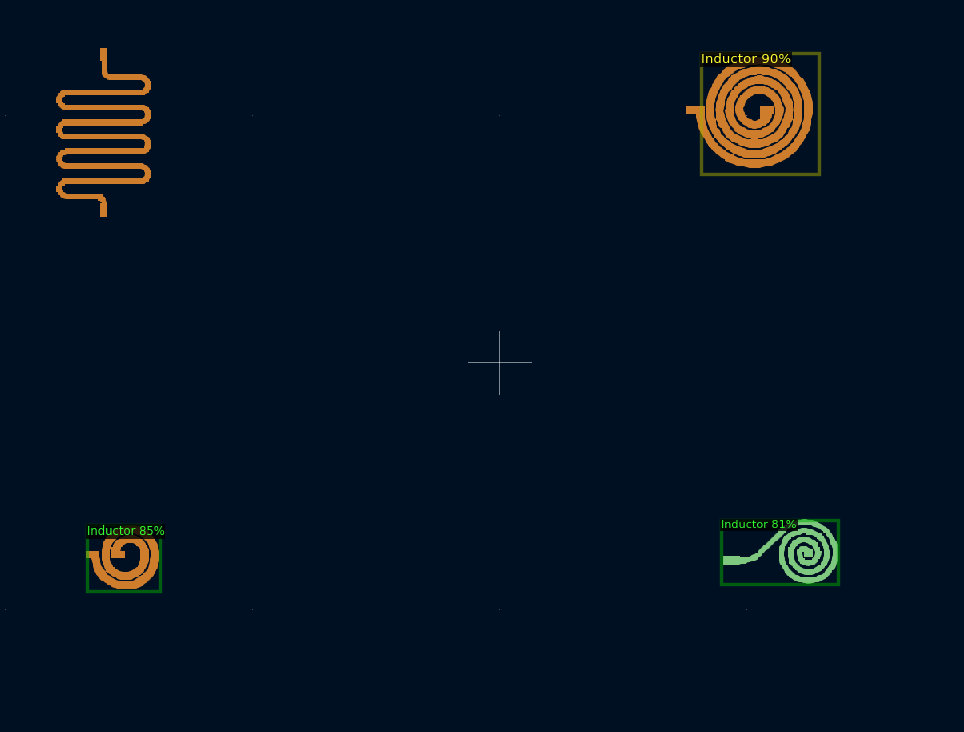

In [ ]:
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
import cv2

from google.colab.patches import cv2_imshow

cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/Keysight_assignment/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8
cfg.MODEL.DEVICE = "cuda"

predictor = DefaultPredictor(cfg)


img = cv2.imread("/content/drive/MyDrive/Keysight_assignment/test.png")
outputs = predictor(img)


v = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.8)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

cv2_imshow(out.get_image()[:, :, ::-1])
cv2.waitKey(0)
cv2.destroyAllWindows()